In [146]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

# Кластеризация методом `K-means` для выделения групп объектов

В этой задаче будет рассмотрен метод кластеризации <code>K-means</code> для решения непосредственно задачи кластеризации — задачи выделения схожих структур в данных. Работать будем с известным набором данных <a href="http://yann.lecun.com/exdb/mnist/"><code>MNIST</code></a>.

Загрузим набор данных. Будем использовать только тестовую часть оригинального набора, чтобы сократить время обучения моделей. 

In [88]:
from keras.datasets import mnist
import warnings
warnings.filterwarnings("ignore")

(_,_), (X, y) = mnist.load_data()

Пример вывода нескольких объектов и соответствующих меток классов:

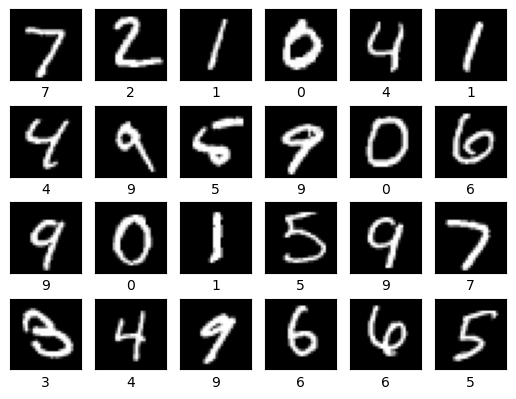

In [89]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(X[i], cmap='gray')
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(y[i],
                   color='black')

Введите <code>.shape</code> полученного набора данных

In [90]:
X.shape, y.shape

((10000, 28, 28), (10000,))

При помощи <code>train_test_split</code> разобейте полученный набор данных на тренеровочную и тестовую выборки с параметрами, указанными в вашем варианте.

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

Давайте, раз речь идет об известном наборе данных, заставим <code>K-means</code> искать $10$ групп объектов.

«Распрямите» изображения и обучите алгоритм <a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html"><code>KMeans</code></a> с параметрами, указанными в вашем задании.

In [92]:
X_train = np.reshape(X_train, (8000, 28*28))
X_test = np.reshape(X_test, (2000, 28*28))

In [93]:
kmeans = KMeans(random_state=33, n_clusters=10)
kmeans.fit(X_train)
clusters = kmeans.labels_ 

Определите чило элементов, отнесенных к кластеру, указанному в вашем задании

In [133]:
unique, counts = np.unique(clusters, return_counts=True)
df = pd.DataFrame(counts, unique)
df['labels'] = counts
df = df.drop(columns=0)
df

,labels
0,628
1,1242
2,974
3,624
4,584
5,1083
6,800
7,579
8,740
9,746


Постройте изображения, соответствующие центроидам полученных кластеров. Для этого `reshape`ните координаты центроидов до размера $28 \times 28$ и постройте полученную матрицу, например, в черно-белых оттенках.



In [95]:
centres = kmeans.cluster_centers_

In [124]:
centres

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [126]:
list(np.unique(clusters, return_counts=True)[1])

[628, 1242, 974, 624, 584, 1083, 800, 579, 740, 746]

In [148]:
X_res = pd.DataFrame(X_train)
X_res['label'] = clusters
X_res.groupby('label')[0].count()

label
0     628
1    1242
2     974
3     624
4     584
5    1083
6     800
7     579
8     740
9     746
Name: 0, dtype: int64

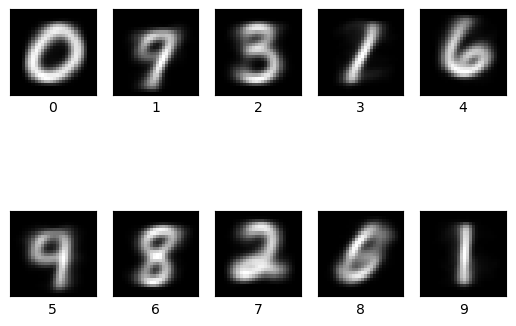

In [143]:
centr = X_res.groupby('label').mean()

fig, ax = plt.subplots(2, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(centr.iloc[i].to_numpy().reshape(28, 28), cmap='gray')
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(centr.iloc[i].name, color='black')

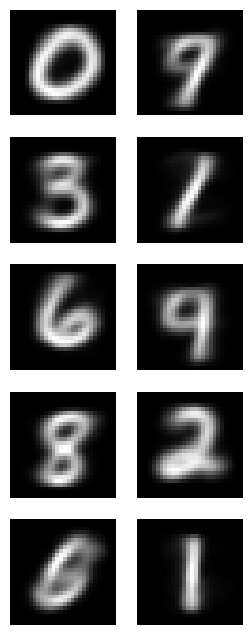

In [136]:
plt.subplots(5, 2, figsize=(3, 8))
for i in range(1, 11):
	plt.axis('off')
	plt.subplot(5, 2, i)
	plt.imshow(centres[i-1].reshape(28, 28), cmap='gray')
plt.show()

Можно заметить, что получившиеся картинки весьма походят на рукописные цифры. Впрочем, кластеризация прошла не без накладок. Предположите, какие цифры могут быть перепутаны и каких не хватает.

Так как получившиеся кластеры ничего не знают о природе кластеризумых объектов, метки кластеров могут отличаться от «разумных меток». Восстановите правильные метки, используя следующие соображения: кластеру присваивается метка тех цифр, представителей которых в кластере большинство. Действительно ли это помогло восстановить справедливость?

Введите полученные метки кластеров после преобразования и сравните с ранее построенными изображениями на основе центроидов. Подтверждаются ли ваши догадки фактами?

In [145]:
X_res['real_label'] = y_train
link = X_res.groupby(['label'])['real_label'].agg(pd.Series.mode)
link

label
0    0
1    7
2    3
3    1
4    6
5    4
6    8
7    2
8    5
9    1
Name: real_label, dtype: uint8

Разумно оценить что-то вроде точности. Считая, что все объекты кластера имеют ту же метку, что и сам кластер, сравните эти метки с истинными метками. Вычислите <code>accuracy</code>. Рекомендуем использовать функцию <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html"><code>accuracy_score</code></a> из библиотеки <code>sklearn</code>.

In [149]:
link_dict = {}
for i, j in enumerate(link):
    link_dict[i] = j
    
smart_labels = np.vectorize(link_dict.get)(clusters)
accuracy_score(smart_labels, y_train)

0.60025

При помощи метода <code>.predict()</code> произведите кластеризацию тестовых данных. Переименуйте метки предсказанных кластеров на основе полученного для тренировочного набора данных преобразования.

In [150]:
y_pred = kmeans.predict(X_test)
accuracy_score(np.vectorize(link_dict.get)(y_pred), y_test)

0.601

Постройте матрицу ошибок.

In [151]:
test_compare = pd.DataFrame(np.vectorize(link_dict.get)(y_pred), columns=['pred'])
test_compare['real'] = y_test
test_compare.groupby('real').agg(pd.Series.mode)

,pred
real,
0,0
1,1
2,2
3,3
4,4
5,3
6,6
7,7
8,8


С какой цифрой построенная модель чаще всего путала цифру, указанную в вашем варианте?

In [101]:
4

Вычислите точность модели на тестовых данных.

In [102]:
# < ENTER YOUR CODE HERE > 

Интересно отметить, что мы построили классификатор на основе кластеризации при том, что никакими «правильными ответами» мы не пользовались (разве что для оценки).

А сколько кластеров кажется оптимальным количеством, если использовать каменистую осыпь? Постройте график каменистой осыпи для числа кластеров от $7$ до $16$. Можно ли уверенно определить оптимальное число кластеров?

In [103]:
# < ENTER YOUR CODE HERE > 

Все эти обучения черезчур уж долгие. Давайте сделаем «ход конем» и понизим размерность данных, пытаясь сохранять расстояния между объектами. Посмотрим, как это скажется на скорости и точности.

Преобразуйте <b>тренировочный набор</b> данных при помощи метода <a href="https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html"><code>TSNE</code></a> из библиотеки <code>sklearn</code>. Используйте параметры, указанные в вашем задании.

In [104]:
# < ENTER YOUR CODE HERE > 

Произведите кластеризацию полученного набора данных при помощи <code>KMeans</code> с параметрами, указанными в вашем задании. Аналогично проделанному раньше переназначьте метки кластеров на основе метки большинства объектов в рамках кластера. Оцените точность модели на <b>тренировочных данных</b>.

In [105]:
# < ENTER YOUR CODE HERE > 

Проблема, однако, известна. `t-SNE` — метод, который не дает правила получения проекций многомерного пространства на, например, двумерное. Тем самым, при появлении новых данных, проекции придется искать заново.

В то же время, еще раз хочется подчеркнуть, как обучение без учителя позволило построить классификатор, который, как будто бы, является результатом решения задачи обучения с учителем.